Aqui, vamos usar um conjunto de dados sobre consumo de energia e vamos entender alguns tópicos:

-  indexação baseada em tempo
-  visualização de dados de séries temporal
-  sazonalidade
-  frequências
-  reamostragem
-  Rolling Windows
-  tendências

Assim como em toda análise, o intuito é obter informações relevantes a partir dos dados. Para tanto, é preciso fazer as corretas perguntas que irão direcionar toda a jornada da análise. No nosso caso, temos essas perguntas:

1) Quando o consumo de eletricidade é tipicamente alto e tipicamente baixo?

2) Como a produção de energia, seja solar ou eólica, varia de acordo com as estações do ano?

3) Quais são as tendências de longo prazo em consumo de energia, produção solar e produção eólica?

4) Como a produção eólica e solar são comparadas com o consumo de energia e como essa taxa varia em relação ao tempo?

## Leitura e breve análise dos dados

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Display figures inline in Jupyter notebook
%matplotlib inline

# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(11, 4)})

In [11]:
opsd_daily = pd.read_csv('opsd_germany_daily.csv')
opsd_daily.shape

(4383, 5)

In [12]:
opsd_daily.head()

,Date,Consumption,Wind,Solar,Wind+Solar
0,2006-01-01,1069.184,NaN,NaN,NaN
1,2006-01-02,1380.521,NaN,NaN,NaN
2,2006-01-03,1442.533,NaN,NaN,NaN
3,2006-01-04,1457.217,NaN,NaN,NaN
4,2006-01-05,1477.131,NaN,NaN,NaN


In [13]:
opsd_daily.tail(3) #tail mostra as n últimas linhas

,Date,Consumption,Wind,Solar,Wind+Solar
4380,2017-12-29,1295.08753,584.277,29.854,614.131
4381,2017-12-30,1215.44897,721.247,7.467,728.714
4382,2017-12-31,1107.11488,721.176,19.980,741.156


In [14]:
opsd_daily.dtypes

Date            object
Consumption    float64
Wind           float64
Solar          float64
Wind+Solar     float64
dtype: object

podemos ver que a coluna Date é um objeto, indicando que o Pandas a trata como texto. Precisamos convertê-la para valores date/time.

In [15]:
opsd_daily['Date'] = pd.to_datetime(opsd_daily['Date'])
opsd_daily.dtypes

Date           datetime64[ns]
Consumption           float64
Wind                  float64
Solar                 float64
Wind+Solar            float64
dtype: object

In [16]:
opsd_daily = opsd_daily.set_index('Date')
opsd_daily.head(3)

,Consumption,Wind,Solar,Wind+Solar
Date,,,,
2006-01-01,1069.184,NaN,NaN,NaN
2006-01-02,1380.521,NaN,NaN,NaN
2006-01-03,1442.533,NaN,NaN,NaN


In [17]:
opsd_daily['Year'] = opsd_daily.index.year
opsd_daily['Month'] = opsd_daily.index.month
opsd_daily['Weekday Name'] = opsd_daily.index.weekday_name

In [18]:
#Mostrando 5 linhas aleatórias
opsd_daily.sample(5, random_state=0) #random_state = seed

,Consumption,Wind,Solar,Wind+Solar,Year,Month,Weekday Name
Date,,,,,,,
2008-08-23,1152.011,NaN,NaN,NaN,2008,8,Saturday
2013-08-08,1291.984,79.666,93.371,173.037,2013,8,Thursday
2009-08-27,1281.057,NaN,NaN,NaN,2009,8,Thursday
2015-10-02,1391.050,81.229,160.641,241.870,2015,10,Friday
2009-06-02,1201.522,NaN,NaN,NaN,2009,6,Tuesday


## Indexação baseada em tempo

In [19]:
# selecionando dados referente a um único dia
opsd_daily.loc['2017-08-10']

Consumption      1351.49
Wind             100.274
Solar              71.16
Wind+Solar       171.434
Year                2017
Month                  8
Weekday Name    Thursday
Name: 2017-08-10 00:00:00, dtype: object

In [20]:
# selecionando dados referente a um bloco de dias
opsd_daily.loc['2014-01-20':'2014-01-22']

,Consumption,Wind,Solar,Wind+Solar,Year,Month,Weekday Name
Date,,,,,,,
2014-01-20,1590.687,78.647,6.371,85.018,2014,1,Monday
2014-01-21,1624.806,15.643,5.835,21.478,2014,1,Tuesday
2014-01-22,1625.155,60.259,11.992,72.251,2014,1,Wednesday


In [21]:
# selecionando dados usando string parcial como indexação
#opsd_daily.loc['2006'] seleciona todo o ano de 2006
opsd_daily.loc['2012-02'] # seleciona o mês de fevereiro de 2012

,Consumption,Wind,Solar,Wind+Solar,Year,Month,Weekday Name
Date,,,,,,,
2012-02-01,1511.866,199.607,43.502,243.109,2012,2,Wednesday
2012-02-02,1563.407,73.469,44.675,118.144,2012,2,Thursday
2012-02-03,1563.631,36.352,46.510,82.862,2012,2,Friday
2012-02-04,1372.614,20.551,45.225,65.776,2012,2,Saturday
2012-02-05,1279.432,55.522,54.572,110.094,2012,2,Sunday
2012-02-06,1574.766,34.896,55.389,90.285,2012,2,Monday
2012-02-07,1615.078,100.312,19.867,120.179,2012,2,Tuesday
2012-02-08,1613.774,93.763,36.930,130.693,2012,2,Wednesday
2012-02-09,1591.532,132.219,19.042,151.261,2012,2,Thursday


## Visualizando dados de séries temporais

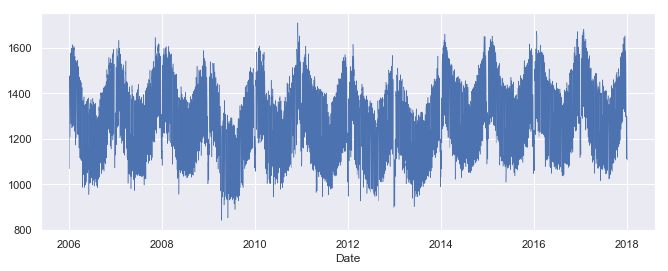

In [22]:
opsd_daily['Consumption'].plot(linewidth=0.5);

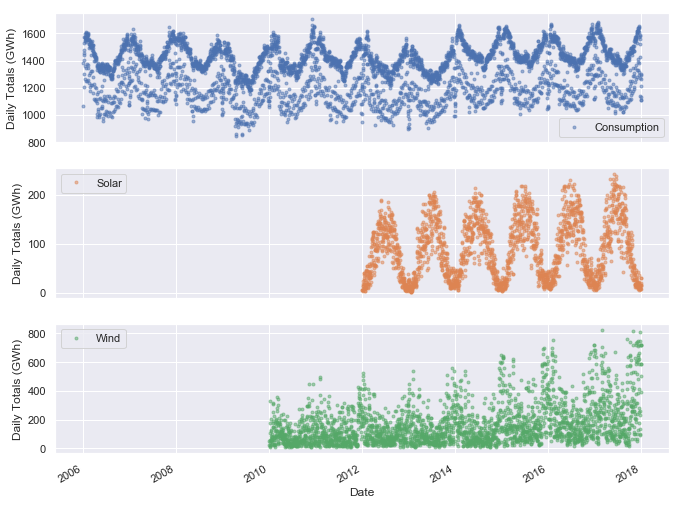

In [23]:
cols_plot = ['Consumption', 'Solar', 'Wind']
axes = opsd_daily[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True)
for ax in axes:
    ax.set_ylabel('Daily Totals (GWh)')

Podemos tirar algumas conclusões:

> o consumo de energia é maior no inverso (aquecedor e iluminação) e menor no verão
> é possível observar dois agrupamentos em relação ao consumo: um em azul mais escuro e o outro em azul mais claro. Vamos investigar isso melhor depois
> a produção de energia solar é maior no verão e menor no inverno
> a produção de energia eólica é maior no inverno e menor no verão
> há uma forte tendência de crescimento na produção de energia eólica ao longo dos anos

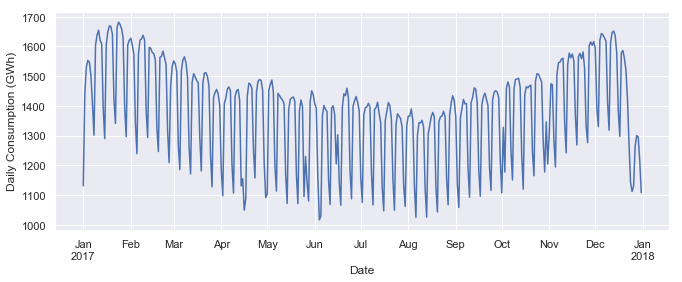

In [24]:
ax = opsd_daily.loc['2017', 'Consumption'].plot()
ax.set_ylabel('Daily Consumption (GWh)');

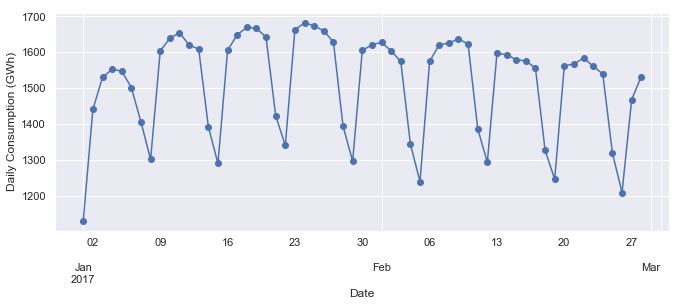

In [25]:
ax = opsd_daily.loc['2017-01':'2017-02', 'Consumption'].plot(marker='o', linestyle='-')
ax.set_ylabel('Daily Consumption (GWh)');

## Sazonalidade

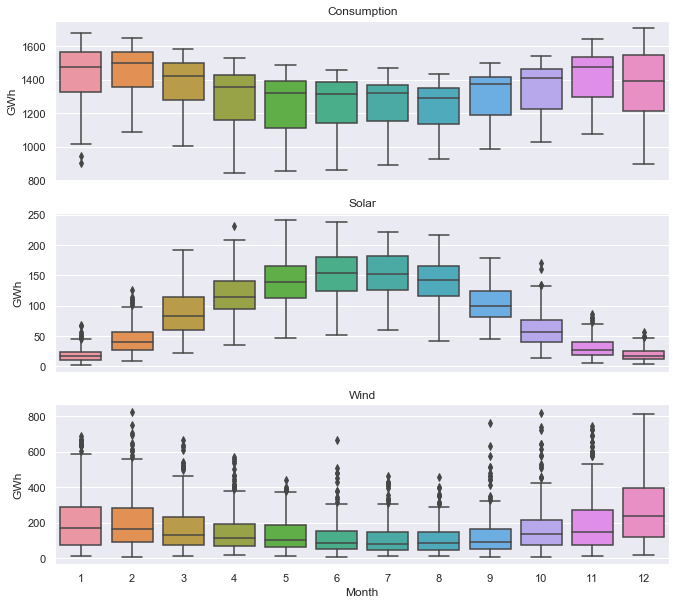

In [41]:
fig, axes = plt.subplots(3, 1, figsize=(11, 10), sharex=True)
for name, ax in zip(['Consumption', 'Solar', 'Wind'], axes):
    sns.boxplot(data=opsd_daily, x='Month', y=name, ax=ax)
    ax.set_ylabel('GWh')
    ax.set_title(name)

    # Remove the automatic x-axis label from all but the bottom subplot
    if ax != axes[-1]:
        ax.set_xlabel('')

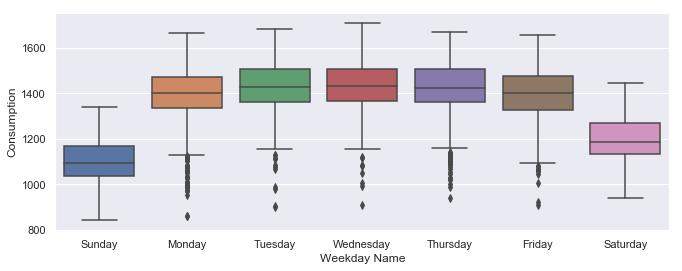

In [27]:
sns.boxplot(data=opsd_daily, x='Weekday Name', y='Consumption');

## Frequências

In [28]:
pd.date_range('1998-03-10', '1998-03-15', freq='D')

DatetimeIndex(['1998-03-10', '1998-03-11', '1998-03-12', '1998-03-13',
               '1998-03-14', '1998-03-15'],
              dtype='datetime64[ns]', freq='D')

Algumas opções de frequenências disponíveis no Pandas são:

    - D: diário
    - H: de horaa em hora
    - B: dia de trabalho
    - W: ssemanalmente
    - M: Mensalmente
    - Q: Quinzenalmente
    - Y: Anualmente

In [29]:
# aqui definimos periods=8, que indica a divisão da freq em periods sequenciais
pd.date_range('2004-09-20', periods=8, freq='H')

DatetimeIndex(['2004-09-20 00:00:00', '2004-09-20 01:00:00',
               '2004-09-20 02:00:00', '2004-09-20 03:00:00',
               '2004-09-20 04:00:00', '2004-09-20 05:00:00',
               '2004-09-20 06:00:00', '2004-09-20 07:00:00'],
              dtype='datetime64[ns]', freq='H')

In [30]:
opsd_daily.index

DatetimeIndex(['2006-01-01', '2006-01-02', '2006-01-03', '2006-01-04',
               '2006-01-05', '2006-01-06', '2006-01-07', '2006-01-08',
               '2006-01-09', '2006-01-10',
               ...
               '2017-12-22', '2017-12-23', '2017-12-24', '2017-12-25',
               '2017-12-26', '2017-12-27', '2017-12-28', '2017-12-29',
               '2017-12-30', '2017-12-31'],
              dtype='datetime64[ns]', name='Date', length=4383, freq=None)

In [31]:
times_sample = pd.to_datetime(['2013-02-03', '2013-02-06', '2013-02-08'])

consum_sample = opsd_daily.loc[times_sample, ['Consumption']].copy()
consum_sample

,Consumption
2013-02-03,1109.639
2013-02-06,1451.449
2013-02-08,1433.098


In [32]:
consum_freq = consum_sample.asfreq('D')

consum_freq['Consumption - Forward Fill'] = consum_sample.asfreq('D', method='ffill')
consum_freq

,Consumption,Consumption - Forward Fill
2013-02-03,1109.639,1109.639
2013-02-04,NaN,1109.639
2013-02-05,NaN,1109.639
2013-02-06,1451.449,1451.449
2013-02-07,NaN,1451.449
2013-02-08,1433.098,1433.098


## Reamostragem

In [33]:
# reamostragem monstrando a média semanal
data_columns = ['Consumption', 'Wind', 'Solar', 'Wind+Solar']

opsd_weekly_mean = opsd_daily[data_columns].resample('W').mean()
opsd_weekly_mean.head(3)

,Consumption,Wind,Solar,Wind+Solar
Date,,,,
2006-01-01,1069.184000,NaN,NaN,NaN
2006-01-08,1381.300143,NaN,NaN,NaN
2006-01-15,1486.730286,NaN,NaN,NaN


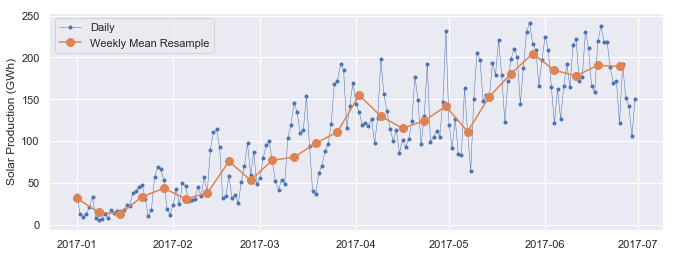

In [34]:
start, end = '2017-01', '2017-06'

fig, ax = plt.subplots()

ax.plot(opsd_daily.loc[start:end, 'Solar'],
        marker='.', linestyle='-', linewidth=0.5, label='Daily')

ax.plot(opsd_weekly_mean.loc[start:end, 'Solar'],
        marker='o', markersize=8, linestyle='-', label='Weekly Mean Resample')

ax.set_ylabel('Solar Production (GWh)')
ax.legend();

## Rolling Windows

In [35]:
opsd_7d = opsd_daily[data_columns].rolling(7, center=True).mean()
opsd_7d.head(10)

,Consumption,Wind,Solar,Wind+Solar
Date,,,,
2006-01-01,NaN,NaN,NaN,NaN
2006-01-02,NaN,NaN,NaN,NaN
2006-01-03,NaN,NaN,NaN,NaN
2006-01-04,1361.471429,NaN,NaN,NaN
2006-01-05,1381.300143,NaN,NaN,NaN
2006-01-06,1402.557571,NaN,NaN,NaN
2006-01-07,1421.754429,NaN,NaN,NaN
2006-01-08,1438.891429,NaN,NaN,NaN
2006-01-09,1449.769857,NaN,NaN,NaN


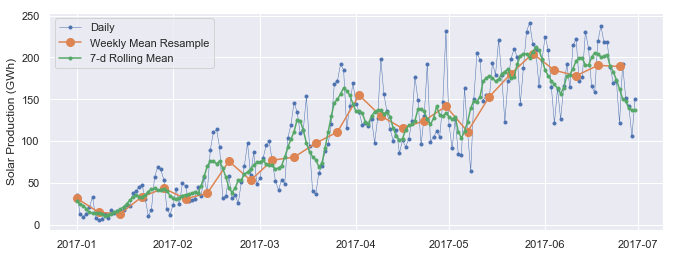

In [36]:
start, end = '2017-01', '2017-06'

fig, ax = plt.subplots()

ax.plot(opsd_daily.loc[start:end, 'Solar'],
        marker='.', linestyle='-', linewidth=0.5, label='Daily')

ax.plot(opsd_weekly_mean.loc[start:end, 'Solar'],
        marker='o', markersize=8, linestyle='-', label='Weekly Mean Resample')

ax.plot(opsd_7d.loc[start:end, 'Solar'],
        marker='.', linestyle='-', label='7-d Rolling Mean')

ax.set_ylabel('Solar Production (GWh)')
ax.legend();

## Tendência

In [37]:
opsd_365d = opsd_daily[data_columns].rolling(window=365, center=True, min_periods=360).mean()

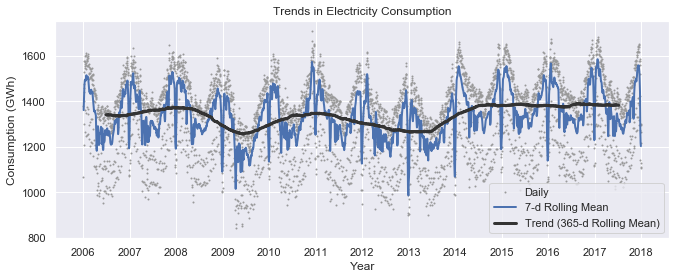

In [38]:
# plot diário, média movel de 7 dias e média movel de 365 dias
import matplotlib.dates as mdates # visuaalizar linhas de grid verticais
fig, ax = plt.subplots()

ax.plot(opsd_daily['Consumption'], marker='.', markersize=2, color='0.6',
        linestyle='None', label='Daily')

ax.plot(opsd_7d['Consumption'], linewidth=2, label='7-d Rolling Mean')

ax.plot(opsd_365d['Consumption'], color='0.2', linewidth=3,
        label='Trend (365-d Rolling Mean)')

ax.xaxis.set_major_locator(mdates.YearLocator())
ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('Consumption (GWh)')
ax.set_title('Trends in Electricity Consumption');

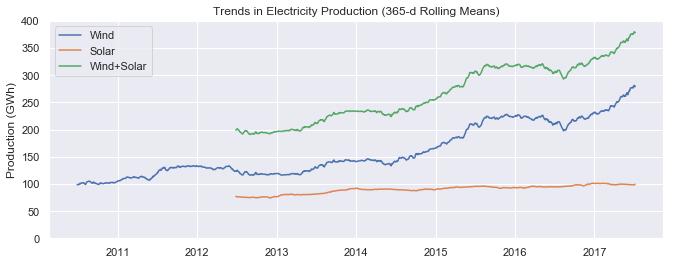

In [39]:
# Plot média móvel de 365 dias de produção de energia solar e eólica
fig, ax = plt.subplots()
for nm in ['Wind', 'Solar', 'Wind+Solar']:
    ax.plot(opsd_365d[nm], label=nm)

ax.xaxis.set_major_locator(mdates.YearLocator())
ax.set_ylim(0, 400)
ax.legend()
ax.set_ylabel('Production (GWh)')
ax.set_title('Trends in Electricity Production (365-d Rolling Means)');

## Leituras adicionais:
    - https://jakevdp.github.io/PythonDataScienceHandbook/03.11-working-with-time-series.html
    - https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html